In [4]:
import numpy as np
import pyshtools as pysh
import matplotlib as plt
import boule as bl
import pandas as pd
import xarray as xr
import harmonica as hm
import verde as vd
import pygmt
from pathlib import Path

In [5]:
def gmtplot(bou_xr):
    with pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0"):
        fig = pygmt.Figure()
        fig.grdimage(
            bou_xr,
            projection="R15c",
            cmap="jet",
            frame="afg",
        )
        fig.colorbar()
        fig.show()

In [ ]:
PROJECT_ROOT = Path.cwd().parent
data_filename=PROJECT_ROOT/"data/boueguer_tesseroid_1deg.csv"
result_filename=PROJECT_ROOT/"data/boueguer_tesseroid_filtered_1deg.csv"

In [8]:
data_filename

WindowsPath('e:/Moho/approaches/approach5/boueguer_tesseroid_1deg.csv')

In [7]:
# 读取数据

df = pd.read_csv(data_filename)

lon_raw = np.sort(df['lon'].unique())
lat_raw = np.sort(df['lat'].unique())

lon_raw = lon_raw - 180

grav_values = df.pivot(index='lat', columns='lon', values='deltaN').loc[lat_raw, df['lon'].unique()].values
topo_values = df.pivot(index='lat', columns='lon', values='topo').loc[lat_raw, df['lon'].unique()].values

lon_grid, lat_grid = np.meshgrid(lon_raw, lat_raw)

grav_da = xr.DataArray(
    grav_values,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw
    },
    name="bouguer_anomaly",
    attrs={"units": "mGal", "long_name": "Bouguer gravity anomaly"}
)

topo_da = xr.DataArray(
    topo_values,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw
    },
    name="topography",
    attrs={"units": "m", "long_name": "Topography height"}
)

ds = xr.Dataset(
    {
        "bouguer_anomaly": grav_da,
        "topography": topo_da
    }
)

FileNotFoundError: [Errno 2] No such file or directory: 'e:\\Moho\\approaches\\approach5\\boueguer_tesseroid_1deg.csv'

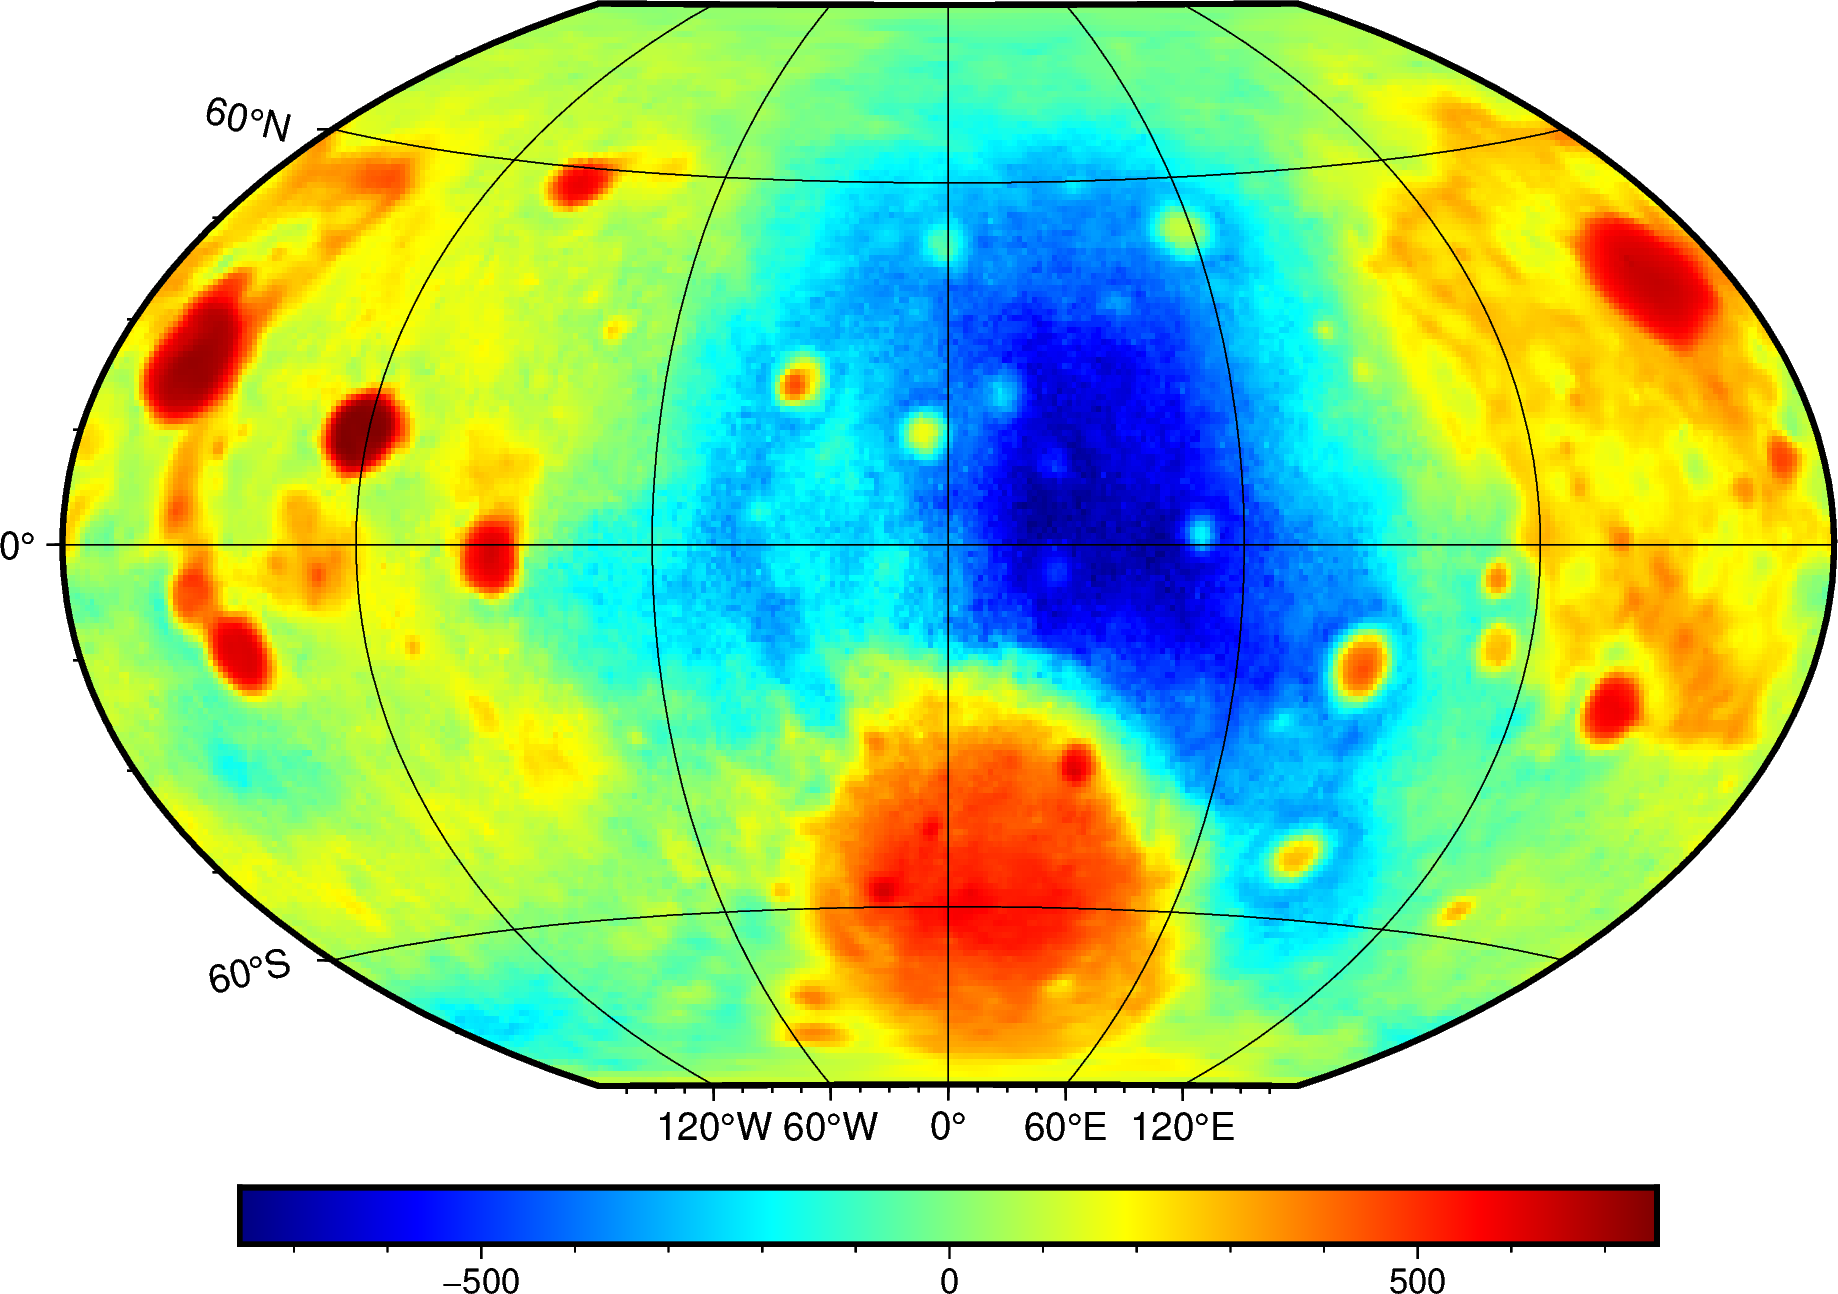

In [ ]:
gmtplot(grav_da)

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

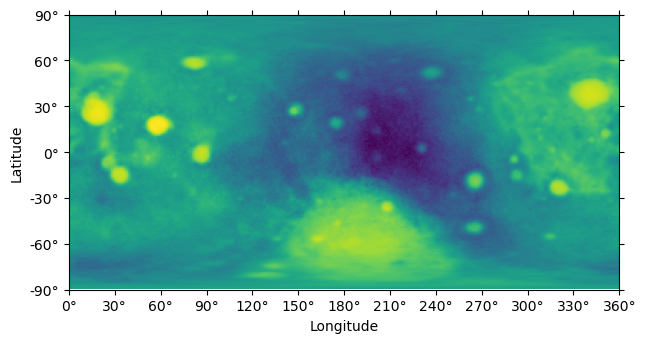

In [ ]:
da_grid=pysh.SHGrid.from_xarray(grav_da)
da_grid.data=np.flip(da_grid.data,0)# 我不知道为啥他出来就是反的
da_grid.plot()

d:\conda_envs\planet\lib\site-packages\pyshtools\shclasses\shcoeffs.py:2665: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power'>)

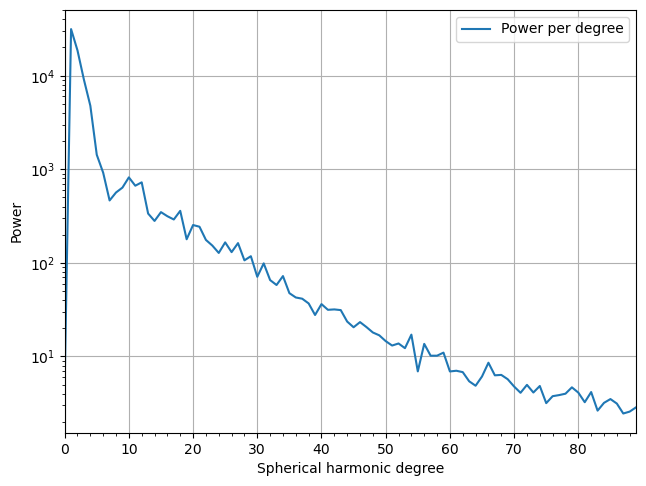

In [ ]:
ba_coff=da_grid.expand()
ba_coff.plot_spectrum()

滤波器

In [ ]:
lmax = ba_coff.lmax
l = np.arange(lmax + 1)

W = np.ones(lmax + 1)
# 1. 去除 l <= 5
W[l <= 2] = 0.0
# 2. 6–20 阶：渐进高通
# 让 W(6)=0, W(9)=0.4, W(20)=1
for i in range(3, 21):
    W[i] = 1

# 3. 20 阶以后：低通（例如指数衰减）
for i in range(21, lmax + 1):
    W[i] = np.exp(-(i - 20) / 10)

In [ ]:
filtered_coeffs = ba_coff.copy()
for l in range(lmax + 1):
    filtered_coeffs.coeffs[:, l, :l+1] *= W[l]

d:\conda_envs\planet\lib\site-packages\pyshtools\shclasses\shcoeffs.py:2665: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power'>)

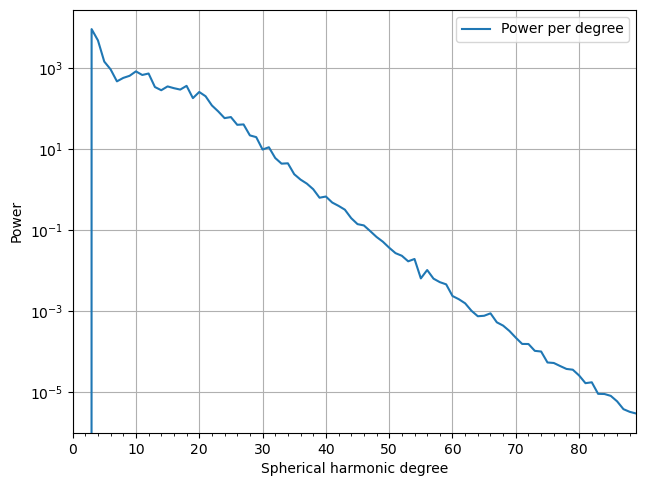

In [ ]:
filtered_coeffs.plot_spectrum()

滤波后

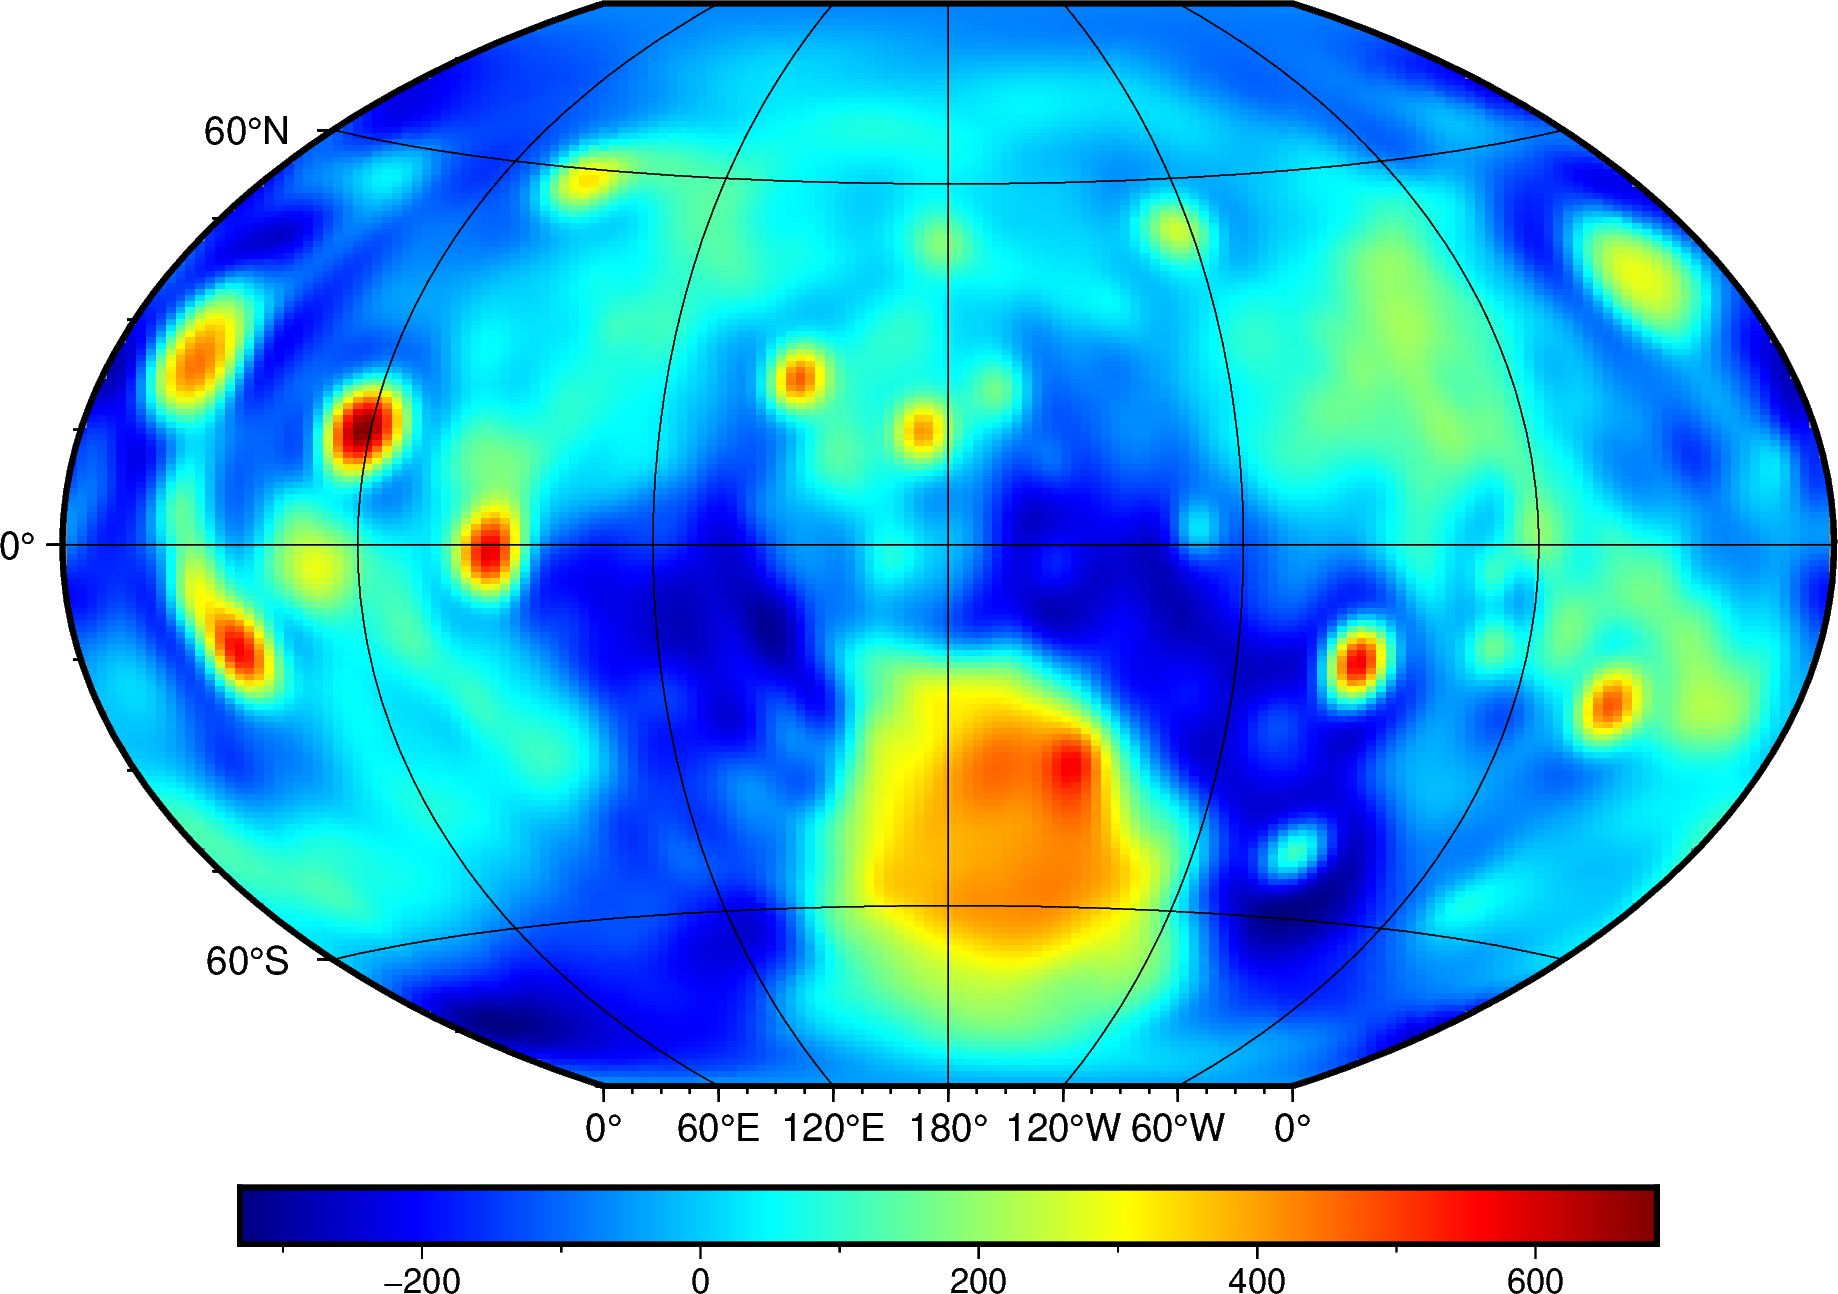

In [ ]:
filtered_grid=filtered_coeffs.expand(grid='DH')
filtered_da=filtered_grid.to_xarray()
gmtplot(filtered_da)

In [ ]:
df=(
    filtered_da
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='deltaN')
    .reset_index(drop=True)
)

topo_da.data=topo_da.data-bl.Moon2015.mean_radius
df_topo=(
    topo_da
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='topo')
    .reset_index(drop=True)
)
df=df.merge(df_topo,on=['lon', 'lat'],how='left')
df.to_csv(
    result_filename,
    index=False,        # 不输出行号
    float_format='%.6f' # 控制浮点精度，重力数据一般够用
)